# ZFOURGE SED Template Processing 
Using the generated ZFOURGE SED templates from the cdfs field, we explore how these SEDs will react in the UVJ colour space to see if the UVJ coordinates are still in the sample place.


In [221]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath


# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
save_outputs = False

In [223]:
# Skirtor models
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

# Read in the AGN templates
type1_agn, type1_params = create_type1_skirtor_agn(skirtor_folderpath)
type2_agn, type2_params = create_type2_skirtor_agn(skirtor_folderpath)

In [224]:


# Choose running parameters

# Template set and AGN type
# Before we begin, lets recall what field we are exploring

field = 'CDFS'
agn_model_name = 'Type1AGN'

# Setup how many alpha values we want to explore
alpha_values = np.linspace(0, 1, 11)

In [225]:
# Choose an AGN model
if agn_model_name == 'Type1AGN':
    agn_model = type1_agn
elif agn_model_name == 'Type2AGN':
    agn_model = type2_agn
else:
    print('AGN model not recognised')

# if field  == 'SWIRE':
#     template_set = swire_templates
#     template_names = template_names
# elif template_set_name == 'Brown':
#     template_set = brown_templates
#     template_names = brown_template_names
# else:
#     print('Template set not recognised')

In [226]:


# We are attempting to read in a new set of SEDs that have been generated using a variation of Michael's ZFOURGE SED processing code.
# the SEDs are in the form of csvs, this can be explored in the zfourge/seds
# directory. The csvs are in the form of:
# Wavelength (microns), Flux Density (10^-19erg_s_cm^2_Angstrom)

zfourge_folderpath = os.path.join('Eazy Template Extractions', 'zfourgeSEDs/'+field+'/')
# We would like to create a function to read this in
def read_zfourge_template(folder_path, name):
    """_summary_

    Args:
        folder_path (string): path to the folder where the SED templates are located
        name (string): name of the object
    
    Returns:
        df: Returns a dataframe containing the SED template
        objname: Returns the name of the object
    """
    folder_path = os.path.join(folder_path)
    files_in_folder = os.listdir(folder_path)

    for file in files_in_folder:
        # Find filepath and convert to df
        
        # get rid of units in the filename
        objname = file.split('SED_')[1]
        
        objname = objname.split('.csv')[0]
        
        if objname == name:
            print("Found object: ", objname)
            filepath = os.path.join(folder_path, file)
            df = pd.read_csv(filepath)
            
            # drop rows with NaN values
            df = df.dropna()
            
            if np.all(df.iloc[:, 1]) == 0.0:
                print("Not including object: ", objname)
                continue
            # our wavelength is in microns, convert to Angstroms
            
            # for the first column, we want to convert to Angstroms
            df.iloc[:, 0] = df.iloc[:, 0] 
            # Name each of the columns appropriately
            df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
            return df, objname
        
    
    return None, None

#df, objname = read_zfourge_template(zfourge_folderpath, 'COSMOS_1') # Test function

In [227]:

def read_zfourge_galaxy_templates(folder_path):
    """_summary_

        Args:
            folder_path (string): path to the folder where the SED templates are located
    
        Returns:
            df_list: Returns a list of dataframes containing the SED templates
            objname_list: Returns a list of the names of the objects
    """
    df_list = []
    objname_list = []
    folder_path = os.path.join(folder_path)
    files_in_folder = os.listdir(folder_path)
    i = 0
    df_dict = {}
    for file in files_in_folder:

        # Find filepath and convert to df
        objname = file.split('SED_')[1]
        objname = objname.split('.csv')[0]
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath)
        
        
        
        
        # check for infinities or null values and replace 
        if np.any(np.isnan(df)):
            df = df.replace([np.inf, -np.inf], np.nan)
        if np.any(np.isinf(df) ):
            df = df.replace([np.inf, -np.inf], np.nan)
        
        
        # Whereever there are NaN values, interpolate
        df = df.interpolate()
        
        
        if np.all(df.iloc[:, 1] == 0.0):
            #print("Not including object: ", objname)
            continue
        
        # Convert microns to angstroms    
        df.iloc[:, 0] = df.iloc[:, 0]
        
        # name each of the columns appropriately
        df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
            
        # Append the dataframe to the list    
        #df_list.append(df)
        #objname_list.append(objname)
        
        # Turn into dictionary
        df_dict[objname] = df
        
    return df_dict


In [228]:
# In addition also use astSED to create filters

# Read in all filters


# UVJ Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')
# Spitzer filters
pb_f3_6_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I1.dat')
pb_f4_5_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I2.dat')
pb_f5_8_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I3.dat')
pb_f8_0_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I4.dat')
# ugr filters
pb_u_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.u_SDSS.dat')
pb_g_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.g_SDSS.dat')
pb_r_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.r_SDSS.dat')


# Load all of the filters 
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)
pb_f3_6 = astSED.Passband(pb_f3_6_path, normalise=False)
pb_f4_5 = astSED.Passband(pb_f4_5_path, normalise=False)
pb_f5_8 = astSED.Passband(pb_f5_8_path, normalise=False)
pb_f8_0 = astSED.Passband(pb_f8_0_path, normalise=False)
pb_u = astSED.Passband(pb_u_path, normalise=False)
pb_g = astSED.Passband(pb_g_path, normalise=False)
pb_r = astSED.Passband(pb_r_path, normalise=False)

filter_set = {'U': pb_U, 'V':pb_V, 'J':pb_J, 'IRAC3.6': pb_f3_6,'IRAC4.5': pb_f4_5,'IRAC5.8': pb_f5_8, 'IRAC8.0':pb_f8_0, 'u': pb_u, 'g': pb_g, 'r':pb_r}


In [229]:
# For plotting
# convert the passbands to arrays
U_arr = np.array(pb_U.asList())
V_arr = np.array(pb_V.asList())
J_arr = np.array(pb_J.asList())

# Effectvie wavelengths
U_eff = pb_U.effectiveWavelength()
V_eff = pb_V.effectiveWavelength()
J_eff = pb_J.effectiveWavelength()

# print 
print("The effective wavelengths are: U: {}, V: {}, J: {}".format(U_eff, V_eff, J_eff))

The effective wavelengths are: U: 3524.656536727612, V: 5525.060451799561, J: 12393.093155655273


In [230]:
# Read in all the ZFOURGE templates
df_dict = read_zfourge_galaxy_templates(zfourge_folderpath)


In [231]:

# print the number of items in df_list
print(len(df_dict))

print(df_dict)

7313
{'CDFS_10003':       lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
0           9.812714e+01                      1.260512e-02
1           1.013621e+02                      1.297434e-02
2           1.035187e+02                      1.324080e-02
3           1.056754e+02                      1.474527e-02
4           1.078320e+02                      1.755733e-02
...                  ...                               ...
2813        8.626562e+05                      9.702369e-08
2814        1.078320e+06                      6.171097e-08
2815        1.293984e+06                      4.347275e-08
2816        1.509648e+06                      3.243082e-08
2817        1.725312e+06                      2.507815e-08

[2818 rows x 2 columns], 'CDFS_10005':       lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
0           9.135086e+01                      2.028206e-02
1           9.436243e+01                      2.057896e-02
2           9.637013e+01                      2.097557e

In [261]:
len(useable_ids)

30849

In [232]:
# Check for null values within the dictionary
for key in df_dict.keys():
    if np.any(np.isnan(df_dict[key])):
        print("Found null values in: ", key)
        

Found null values in:  CDFS_16571
Found null values in:  CDFS_17967
Found null values in:  CDFS_21156
Found null values in:  CDFS_9500


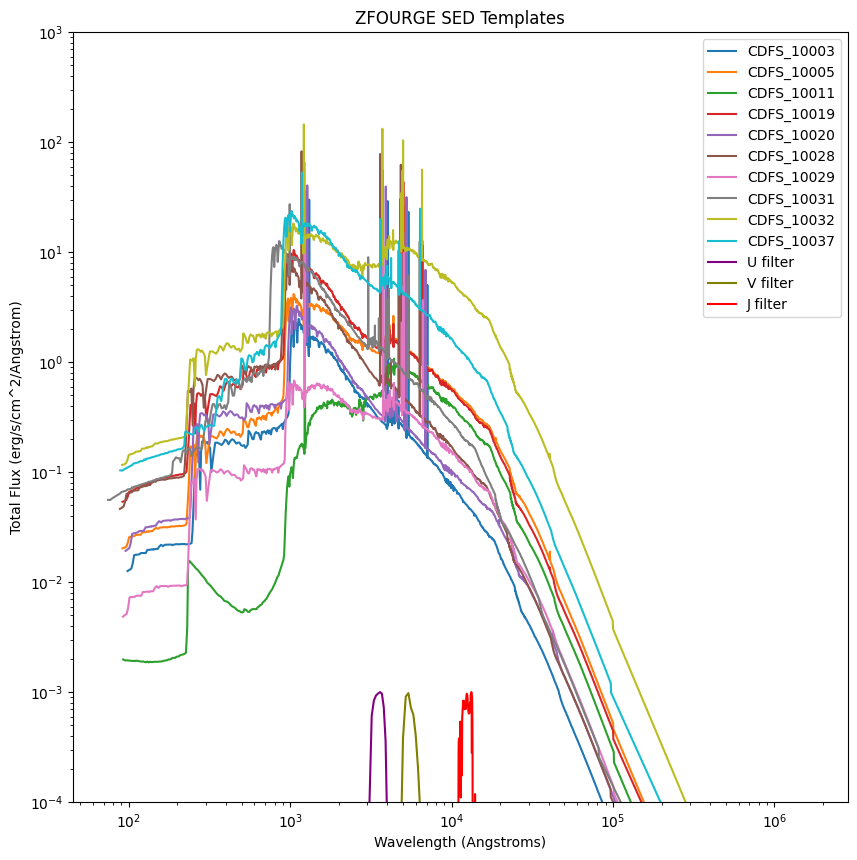

In [233]:
# Plot all of the SEDS

# for each sed, cut it so the wavelength is between 10^2 and 10^5
# then plot it
#for i in range(len(df_list)):
   # df_list[i] = df_list[i][(df_list[i]['lambda (Angstroms)'] > 10**2) & (df_list[i]['lambda (Angstroms)'] < 10**5)]

# Plot the first 10
plt.figure(figsize=(10, 10))
# Plot the first 10 entries of the dictonary
for i, key in enumerate(list(df_dict.keys())[:10]):
    plt.loglog(df_dict[key].iloc[:, 0], df_dict[key].iloc[:, 1], label=key)
    
#plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.title('ZFOURGE SED Templates')
sc = 10**-3
# additionally plot the relatively locations of the filters
plt.loglog(U_arr[:, 0], sc*U_arr[:,1], label='U filter', c='purple')
plt.loglog(V_arr[:, 0], sc*V_arr[:,1], label='V filter', c='olive')
plt.loglog(J_arr[:, 0], sc*J_arr[:,1], label='J filter', c='red')

plt.ylim(10**-4, 10**3)

plt.legend()

plt.show()




We can see a very very clear trend of the seds now being alligned in their rest frame. The lyman break is clearly visible and the absorption and emission lines are also very clear. This is a very good sign that the SEDs are being generated correctly.

In [234]:
# Use a similar method to the one use in the theoretical modelling output notebook.

# First read in the ZFOURGE seds from a fits file and only use id's with good photometry
# read in the useable ids
useable_ids_df = pd.read_csv('outputs/useable_zfourge_ids.csv')

In [235]:
# create dictionary
df_dict

{'CDFS_10003':       lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
 0           9.812714e+01                      1.260512e-02
 1           1.013621e+02                      1.297434e-02
 2           1.035187e+02                      1.324080e-02
 3           1.056754e+02                      1.474527e-02
 4           1.078320e+02                      1.755733e-02
 ...                  ...                               ...
 2813        8.626562e+05                      9.702369e-08
 2814        1.078320e+06                      6.171097e-08
 2815        1.293984e+06                      4.347275e-08
 2816        1.509648e+06                      3.243082e-08
 2817        1.725312e+06                      2.507815e-08
 
 [2818 rows x 2 columns],
 'CDFS_10005':       lambda (Angstroms)  Total Flux (erg/s/cm^2/Angstrom)
 0           9.135086e+01                      2.028206e-02
 1           9.436243e+01                      2.057896e-02
 2           9.637013e+01                   

In [236]:
# print the info on the redshift
print(useable_ids_df['z'].describe())

count    30849.000000
mean         1.393210
std          0.770743
min          0.200200
25%          0.742900
50%          1.252900
75%          1.959000
max          3.199500
Name: z, dtype: float64


In [237]:
useable_ids_df

# Append the field to the front of the id
# Make the id column have the field appended to the front
useable_ids_df['id'] = useable_ids_df['field'] + '_' + useable_ids_df['id'].astype(str)

# Uppercase everything
useable_ids_df['id'] = useable_ids_df['id'].str.upper()

0        CDFS_5746
1        CDFS_5860
2        CDFS_5880
3        CDFS_5886
4        CDFS_5928
           ...    
30844    UDS_22078
30845    UDS_22086
30846    UDS_22087
30847    UDS_22089
30848    UDS_22090
Name: id, Length: 30849, dtype: object
count    30849.000000
mean         1.393210
std          0.770743
min          0.200200
25%          0.742900
50%          1.252900
75%          1.959000
max          3.199500
Name: z, dtype: float64


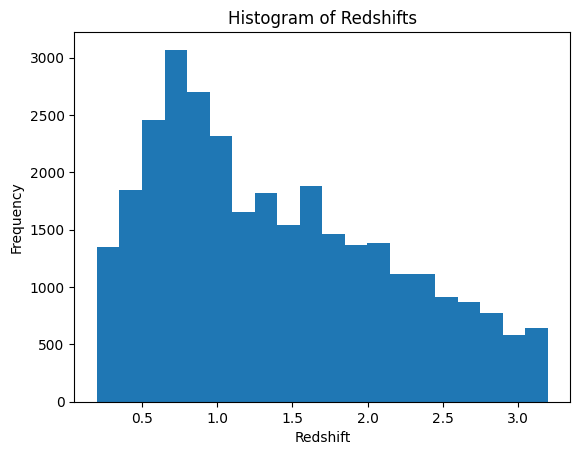

In [238]:
print(useable_ids_df['id'])

# check the redshift range
print(useable_ids_df['z'].describe())

# Plot a histogram of the redshifts
plt.hist(useable_ids_df['z'], bins=20)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title('Histogram of Redshifts')
plt.show()


In [258]:
# Check if the id is in the dictionary
df_dict.keys()

dict_keys(['CDFS_10003', 'CDFS_10005', 'CDFS_10011', 'CDFS_10019', 'CDFS_10020', 'CDFS_10028', 'CDFS_10029', 'CDFS_10031', 'CDFS_10032', 'CDFS_10037', 'CDFS_10039', 'CDFS_10040', 'CDFS_10042', 'CDFS_10044', 'CDFS_10045', 'CDFS_10051', 'CDFS_10056', 'CDFS_10059', 'CDFS_10062', 'CDFS_10065', 'CDFS_10067', 'CDFS_10072', 'CDFS_10073', 'CDFS_10074', 'CDFS_10077', 'CDFS_10086', 'CDFS_10100', 'CDFS_10104', 'CDFS_10105', 'CDFS_10107', 'CDFS_10113', 'CDFS_10114', 'CDFS_10115', 'CDFS_10116', 'CDFS_10126', 'CDFS_10136', 'CDFS_10137', 'CDFS_10138', 'CDFS_10139', 'CDFS_10140', 'CDFS_10141', 'CDFS_10153', 'CDFS_10160', 'CDFS_10162', 'CDFS_10163', 'CDFS_10167', 'CDFS_10169', 'CDFS_10173', 'CDFS_10186', 'CDFS_10188', 'CDFS_10192', 'CDFS_10194', 'CDFS_10197', 'CDFS_10207', 'CDFS_10209', 'CDFS_10210', 'CDFS_10217', 'CDFS_10218', 'CDFS_10220', 'CDFS_10223', 'CDFS_10232', 'CDFS_10233', 'CDFS_10236', 'CDFS_10238', 'CDFS_10240', 'CDFS_10243', 'CDFS_10244', 'CDFS_10253', 'CDFS_10254', 'CDFS_10256', 'CDFS_102

In [ ]:
for key in df_dict.keys():
    if key in useable_ids_df['id'].values:
        print("Found: ", key)
    

In [ ]:
    
# redshift
redshifts = []

# Create a new dictionary with only the useable ids
useable_dict = {}
for key in df_dict.keys():
    if key in useable_ids_df['id'].values:
        useable_dict[key] = df_dict[key]
        
        redshifts.append(useable_ids_df[useable_ids_df['id'] == key]['z'].values[0])
        
        # I suspect that eazy had trouble fitting higher redshfit templates and potentially ignored them.
        # This code is causing the redshifts to be taken away
# Check redshift for first entry
print(redshifts[0])

In [255]:
# describe the redshifts
print(pd.Series(redshifts).describe())

count    7313.000000
mean        1.060341
std         0.466974
min         0.201300
25%         0.677100
50%         1.025600
75%         1.435400
max         1.999700
dtype: float64


The redshift range is:  0.2013 1.9997


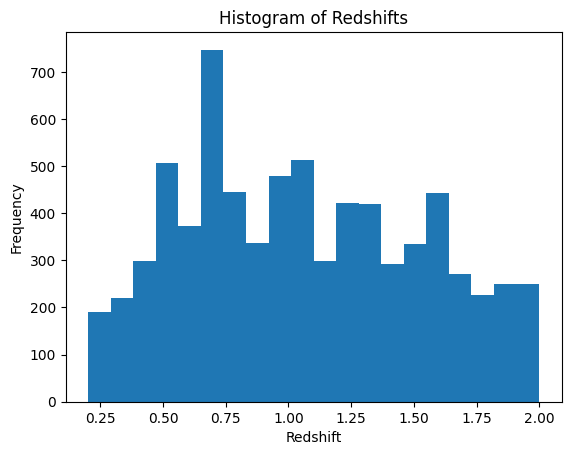

In [240]:
# Check the redshift range
print("The redshift range is: ", min(redshifts), max(redshifts))
# Plot the redshifts
plt.hist(redshifts, bins=20)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title('Histogram of Redshifts')
plt.show()


7313
7313


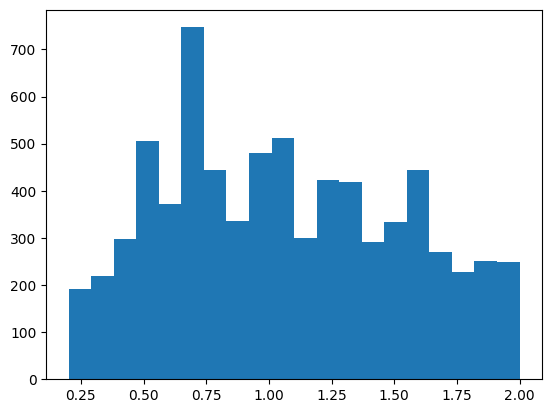

1.9997


In [241]:
# Check the number of items in the dictionary
print(len(useable_dict))
print(len(redshifts))

# Look at the redshifts
plt.hist(redshifts, bins=20)
plt.show()
# print the largest redshift
print(max(redshifts))

In [242]:
# Create a new dictionary with only the useable ids in it added 
useable_df_dict = useable_dict

In [243]:
# Total useable ids
print(len(useable_df_dict))

7313


In [244]:
# Now that we have all of the useable ids we can now create the models. As we we are intending to use the same sort of method as the theoretical modelling, this will take up a lot of computational resources. 
# To that end, we will randomly sample 150 ids from the useable ids and then create the models for those ids.
# Create an empty data frame for each template that has the filters with the alpha values o.e u_0, u_10, u_20 etc for each filter
column_names = ['id', 'z'] # add an inital column for the redshift and for the ID
# filters 
for filter in filter_set.keys():
    # Check filter we are looking at

    for alpha_val in alpha_values:
    # Add filter into a data frame
        column_names.append(filter + '_' + str(int(round(alpha_val, 2)*100)))



# Turn into a dataframe  
composite_fluxes = pd.DataFrame(columns=column_names)

In [245]:
composite_fluxes # There will be no redshift information in this dataframe (this will need to be added at a later date)

Empty DataFrame
Columns: [id, z, U_0, U_10, U_20, U_30, U_40, U_50, U_60, U_70, U_80, U_90, U_100, V_0, V_10, V_20, V_30, V_40, V_50, V_60, V_70, V_80, V_90, V_100, J_0, J_10, J_20, J_30, J_40, J_50, J_60, J_70, J_80, J_90, J_100, IRAC3.6_0, IRAC3.6_10, IRAC3.6_20, IRAC3.6_30, IRAC3.6_40, IRAC3.6_50, IRAC3.6_60, IRAC3.6_70, IRAC3.6_80, IRAC3.6_90, IRAC3.6_100, IRAC4.5_0, IRAC4.5_10, IRAC4.5_20, IRAC4.5_30, IRAC4.5_40, IRAC4.5_50, IRAC4.5_60, IRAC4.5_70, IRAC4.5_80, IRAC4.5_90, IRAC4.5_100, IRAC5.8_0, IRAC5.8_10, IRAC5.8_20, IRAC5.8_30, IRAC5.8_40, IRAC5.8_50, IRAC5.8_60, IRAC5.8_70, IRAC5.8_80, IRAC5.8_90, IRAC5.8_100, IRAC8.0_0, IRAC8.0_10, IRAC8.0_20, IRAC8.0_30, IRAC8.0_40, IRAC8.0_50, IRAC8.0_60, IRAC8.0_70, IRAC8.0_80, IRAC8.0_90, IRAC8.0_100, u_0, u_10, u_20, u_30, u_40, u_50, u_60, u_70, u_80, u_90, u_100, g_0, g_10, g_20, g_30, g_40, g_50, g_60, g_70, g_80, g_90, ...]
Index: []

[0 rows x 112 columns]

In [246]:

# Split the dictionary up again - into sed/name
useable_seds = list(useable_df_dict.values())
useable_names = list(useable_df_dict.keys())


In [247]:

# associated redshift for the useable_names
# Read in the redshifts -  redshifts are in the 

In [248]:
# Create the composites
# Create all of the composites
composites = generate_composite_set(agn_model, useable_seds, alpha_values)

c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\carf.py:691: RuntimeWarning: invalid value encountered in scalar divide
  scaling_factor = integrated_galaxy_flux/integrated_agn_flux
c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\carf.py:691: RuntimeWarning: invalid value encountered in scalar divide
  scaling_factor = integrated_galaxy_flux/integrated_agn_flux
c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\carf.py:691: RuntimeWarning: invalid value encountered in scalar divide
  scaling_factor = integrated_galaxy_flux/integrated_agn_flux
c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\carf.py:691: RuntimeWarning: invalid value encountered in scalar divide
  scaling_factor = integrated_galaxy_flux/integrated_agn_flux
c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\carf.py:691: RuntimeWarning: invalid value encountered in scalar divide
  scaling_factor = integrated_galaxy_flux/integrated_agn_flux
c:\Users\Mitchell\Documents\GitHub\Honou

In [249]:
#len(composites[0])

In [250]:
# For each in the dictionary
flux_df = composite_fluxes.copy()
composite_fluxes_list = []

for i in range(len(alpha_values)):
        # This will be the set of composites for the specific alpha value
        sed_alpha_data = composites[i]
        
        for j, sed_data in enumerate(sed_alpha_data):
            # Create an SED object using astSED
        
            #print(sed_data['lambda (Angstroms)'])
            wl = sed_data['lambda (Angstroms)']
            fl = sed_data['Total Flux (erg/s/cm^2/Angstrom)']
            
            # Create an SED object
            sed = astSED.SED(wavelength=wl, flux=fl, z=0.0)
            

            # We could also add a a section here and we create a new column for a redshift of not 0.
            
            # Only do this for the first iteration
            if i == 0: # Remove this if it keeps adding more data     
                # Add template name to the data frame in the id column
                flux_df.loc[j, 'id'] = useable_names[j]
                
                # Add redshift information
                flux_df.loc[j, 'z'] = redshifts[j]
                
            # Only turn this on to output all seds
            # Only necessary to output the CSV for the rest frame
            
            # Maybe add this when we subset what we want 
            #sed_data.to_csv(f'outputs/composite_seds/{template_set_name}/'+template_names[j]+ f'{agn_model_name}'+ 'composite_' +str(int(round(alpha_values[i], 2)*100))+'.csv') <- don't do this but if i need to explore get them to be printed out later 
            # or get a new script to perform the calculation on specific ones again.
            
            # Calculate each filter value for the specific alpha value
            for filter in filter_set.keys():
                # Calculate the magnitude for the filter
                
                # We will need to create the restframe colours using a restframe SED
                if filter == 'U' or filter == 'V' or filter == 'J':
                    
                    # Ensure the sed is restframe
                    sed.redshift(0)
                    
                    # Calculate the magnitude for the filter
                    mag = astSED.SED.calcMag(sed, filter_set[filter], magType='AB')
                    
                    # Add the magnitude to the data frame
                    flux_df.loc[j, filter + '_' + str(int(round(alpha_values[i], 2)*100))] = mag
                    
                else:
                    # Check redshift, if restframed then shift to appropriate redshift 
                    sed.redshift(redshifts[j]) 
                    
                    # IRAC fluxes are observed frame, calculate the flux.
                    if filter == 'IRAC3.6' or filter == 'IRAC4.5' or filter == 'IRAC5.8' or filter == 'IRAC8.0':
                        
                        # Redshift the SED to the specified redshift
                        #sed.z = redshift
                        
                        # Calculate the magnitude for the IRAC filters
                        obs_flux = astSED.SED.calcFlux(sed, filter_set[filter])  
                        # Add the magnitude to the data frame
                        flux_df.loc[j, filter + '_' + str(int(round(alpha_values[i], 2)*100))] = obs_flux
                    
                    else:    
                        # Calculate the magnitude for the other filters
                        mag = astSED.SED.calcMag(sed, filter_set[filter], magType='AB')
                        # Add the magnitude to the data frame
                        flux_df.loc[j, filter + '_' + str(int(round(alpha_values[i], 2)*100))] = mag
                
    # Add the redshift to the data frame
    #flux_df['z'] = redshift
        composite_fluxes_list.append(flux_df)


c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\astLib\astSED.py:379: RuntimeWarning: invalid value encountered in scalar divide
  self.flux=self.flux*(z0TotalFlux/zTotalFlux)
c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\astLib\astSED.py:463: RuntimeWarning: invalid value encountered in scalar divide
  totalFlux=totalFlux/numpy.trapz(passband.interpolator(sedWavelengthSlice)\
c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\astLib\astSED.py:379: RuntimeWarning: invalid value encountered in scalar divide
  self.flux=self.flux*(z0TotalFlux/zTotalFlux)
c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\astLib\astSED.py:463: RuntimeWarning: invalid value encountered in scalar divide
  totalFlux=totalFlux/numpy.trapz(passband.interpolator(sedWavelengthSlice)\
c:\Users\Mitchell\Documents\GitHub\HonoursResearchProject\astLib\astSED.py:379: RuntimeWarning: invalid value encountered in scalar divide
  self.flux=self.flux*(z0TotalFlux/zTotalFlux)
c:\Users\M

In [251]:

# This ensures we have restframe colours for the U, V and J filters, and observed frame fluxes for the IRAC/ugr filters. 
# This will provide a good testing grounds.
composite_fluxes = pd.concat(composite_fluxes_list)

# Output as required
composite_choice = f'{field}_obsevational_composites_fluxes{agn_model_name}'
composite_fluxes.to_csv(f'outputs\composite_seds\{composite_choice}.csv')   



In [252]:
composite_fluxes

# Drop duplicates
composite_fluxes = composite_fluxes.drop_duplicates(subset='id')


In [253]:
# Have a look for the largest redshift
composite_fluxes['z'].max()


1.9997

In [254]:
# We would then like to export this to a csv file with the appropriate naming convention
